In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

import time

In [18]:
def bigrams(words):
    bigrams = []
    for b in words:
        bigrams.append([b[i:i+2] for i in range(len(b)-1)])
    return bigrams

In [19]:
df = pd.read_csv('./data/dataset.csv')
print('data shape: {}'.format(df.shape))

X = df['NAME']
y = df['NATIONALITY']
# print(X)

classes = y.unique()
print(classes)
num_classes = len(y.unique())

print('number of classes: {}'.format(num_classes))

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2, random_state=69)

print('train data shape X, y: {},{}'.format(X_train_df.shape, y_train_df.shape))
print('test data shape X, y: {},{}'.format(X_test_df.shape, y_test_df.shape))

data shape: (7125, 2)
['List_of_Germans' 'List_of_Japanese_people' 'List_of_Poles']
number of classes: 3
train data shape X, y: (5700,),(5700,)
test data shape X, y: (1425,),(1425,)


In [20]:
X_tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
          lower=False, char_level=True, oov_token=None)

y_tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
          lower=True, char_level=False, oov_token=None)

In [21]:
X_train = X_train_df.values.astype(str) # Otherwise, there's an error when calling 'fit_on_texts' >> AttributeError: 'int' object has no attribute 'lower'
X_test = X_test_df.values.astype(str) # Otherwise, there's an error when calling 'fit_on_texts' >> AttributeError: 'int' object has no attribute 'lower'

# X_train = bigrams(X_train)

X_tokenizer.fit_on_texts(X_train)
X_train = X_tokenizer.texts_to_sequences(X_train)
X_test = X_tokenizer.texts_to_sequences(X_test)

print(len(X_tokenizer.index_word))

X_train = X_tokenizer.sequences_to_matrix(X_train, mode='tfidf')
X_test = X_tokenizer.sequences_to_matrix(X_test, mode='tfidf')

# X_train = X_tokenizer.sequences_to_matrix(X_train, mode='freq')
# X_test = X_tokenizer.sequences_to_matrix(X_test, mode='freq')


54


In [22]:
# encode from string labels to numerical labels 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_df.values.astype(str)) # error without astype(str)
y_test = label_encoder.transform(y_test_df.values.astype(str))
# print(encoder.classes_.shape)
# encoder.inverse_transform(y_train)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [23]:
X_tokenizer.word_counts
len(X_tokenizer.word_counts)

54

In [27]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras import optimizers
from keras.utils.vis_utils import plot_model

max_features = len(X_tokenizer.word_counts)
# print(max_features)
batch_size = 23
maxlen = 30
embedding_dims = 50
epochs=20

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, padding="post", maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Hyperparameters')
print('max_features = {}'.format(max_features))
print('batch_size = {}'.format(batch_size))
print('maxlen = {}'.format(maxlen))
print('embedding_dims = {}'.format(embedding_dims))
print('epochs = {}'.format(epochs))

print('Build model...')
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
# model.add(SimpleRNN(embedding_dims))

model.add(LSTM(maxlen))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

print('Train...')
begin = time.perf_counter()

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test)
         )

end_fit = time.perf_counter()

score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size,
                           verbose=1)

end_eval = time.perf_counter()

print('Test score:', score)
print('Test accuracy:', acc)

print('fit time = {}', end_fit - begin)
print('eval time = {}', end_eval - end_fit)

5700 train sequences
1425 test sequences
Pad sequences (samples x time)
X_train shape: (5700, 30)
X_test shape: (1425, 30)
Hyperparameters
max_features = 54
batch_size = 23
maxlen = 30
embedding_dims = 50
epochs = 20
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 50)            2700      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 93        
Total params: 12,513
Trainable params: 12,513
Non-trainable params: 0
_________________________________________________________________
None
Train...
Train on 5700 samples, validate on 1425 samples
Epoch 1/20
5700/5700 [==============================] - 7s 1ms/step - loss: 1.0560 - acc: 0.4304 - val_loss:

In [25]:
results = model.predict(X_test)
results.shape
len(results)
results

array([[0.34260586, 0.21461077, 0.44278336],
       [0.3426233 , 0.21472253, 0.44265422],
       [0.34260586, 0.21461077, 0.44278336],
       ...,
       [0.34260586, 0.21461077, 0.44278336],
       [0.34260586, 0.21461077, 0.44278336],
       [0.34260586, 0.21461077, 0.44278336]], dtype=float32)

In [26]:
plot_model(model, to_file='model_plot_6.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


([array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
  array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
  array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 1., 1., 1.

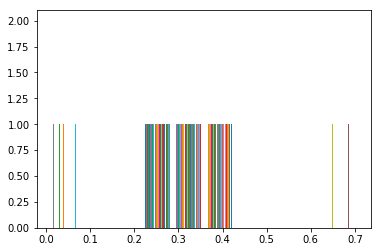

In [15]:
colors = ['#E69F00', '#56B4E9', '#F0E442']
         
plt.hist(results.transpose(), normed=False)

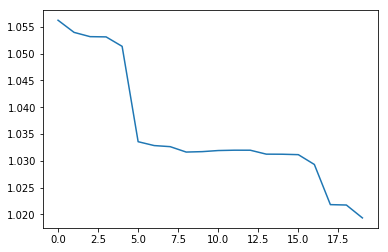

In [16]:
plt.plot(history.history['loss'])